In [190]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [191]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Defining image data path

In [192]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
image_path = Path("/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters")

In [193]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [194]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters'.
There are 23 directories and 0 images in '/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/test'.
There are 0 directories and 145 images in '/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/test/haa1'.
There are 0 directories and 110 images in '/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/test/dhaal'.
There are 0 directories and 145 images in '/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/test/jeem'.
There are 0 directories and 110 images in '/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/test/daal'.
There are 0 directories and 145 images in '/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/test/alif'.
There are 0 directories and 110 images in '/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/test/noonghunna'.
There are 0 directories and 110 images in '/content/drive/MyDrive/AI_Mini_Project/data/urdu

In [195]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/train'),
 PosixPath('/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/test'))

## Visualize an image

In [196]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

Random image path: /content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/train/haa1/haa1 (361).jpg
Image class: haa1
Image height: 28
Image width: 28


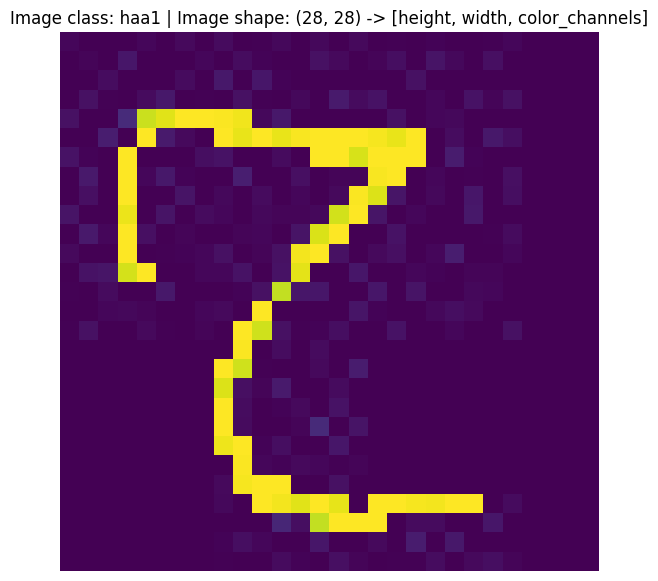

In [197]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Transforming data

In [198]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [199]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

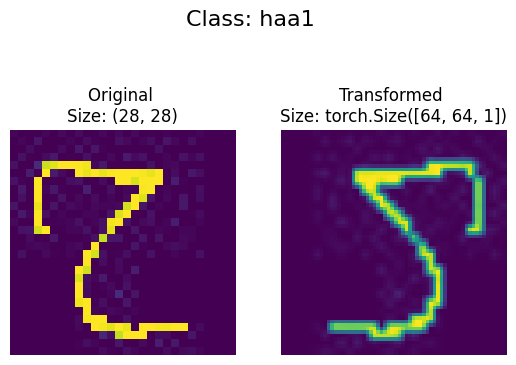

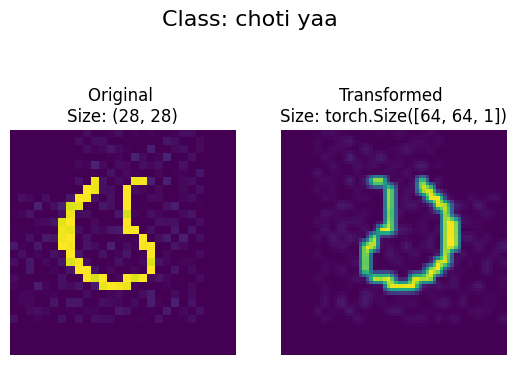

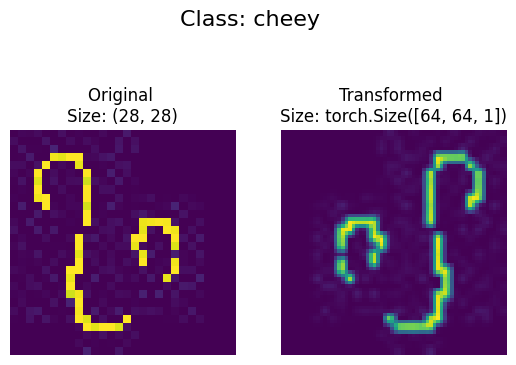

In [200]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

## Loading Image Data with a Custom Dataset

In [201]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

#### Creating a helper function to get class names

In [202]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: /content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/train
Class names found: ['alif', 'alif mad aa', 'ayn', 'baa', 'bari yaa', 'cheey', 'choti yaa', 'daal', 'dhaal', 'faa', 'gaaf', 'ghain', 'haa1', 'haa2', 'haa3', 'hamza', 'jeem', 'kaaf', 'khaa', 'laam', 'meem', 'noon', 'noonghunna']


In [203]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [204]:
find_classes(train_dir)

(['alif',
  'alif mad aa',
  'ayn',
  'baa',
  'bari yaa',
  'cheey',
  'choti yaa',
  'daal',
  'dhaal',
  'faa',
  'gaaf',
  'ghain',
  'haa1',
  'haa2',
  'haa3',
  'hamza',
  'jeem',
  'kaaf',
  'khaa',
  'laam',
  'meem',
  'noon',
  'noonghunna'],
 {'alif': 0,
  'alif mad aa': 1,
  'ayn': 2,
  'baa': 3,
  'bari yaa': 4,
  'cheey': 5,
  'choti yaa': 6,
  'daal': 7,
  'dhaal': 8,
  'faa': 9,
  'gaaf': 10,
  'ghain': 11,
  'haa1': 12,
  'haa2': 13,
  'haa3': 14,
  'hamza': 15,
  'jeem': 16,
  'kaaf': 17,
  'khaa': 18,
  'laam': 19,
  'meem': 20,
  'noon': 21,
  'noonghunna': 22})

In [205]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [206]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [207]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fe48225b5b0>,
 <__main__.ImageFolderCustom at 0x7fe48d8ffb80>)

In [208]:
len(train_data_custom), len(test_data_custom)

(16474, 2837)

In [209]:
class_names = train_data_custom.classes
class_names

['alif',
 'alif mad aa',
 'ayn',
 'baa',
 'bari yaa',
 'cheey',
 'choti yaa',
 'daal',
 'dhaal',
 'faa',
 'gaaf',
 'ghain',
 'haa1',
 'haa2',
 'haa3',
 'hamza',
 'jeem',
 'kaaf',
 'khaa',
 'laam',
 'meem',
 'noon',
 'noonghunna']

In [210]:
train_data_custom.class_to_idx

{'alif': 0,
 'alif mad aa': 1,
 'ayn': 2,
 'baa': 3,
 'bari yaa': 4,
 'cheey': 5,
 'choti yaa': 6,
 'daal': 7,
 'dhaal': 8,
 'faa': 9,
 'gaaf': 10,
 'ghain': 11,
 'haa1': 12,
 'haa2': 13,
 'haa3': 14,
 'hamza': 15,
 'jeem': 16,
 'kaaf': 17,
 'khaa': 18,
 'laam': 19,
 'meem': 20,
 'noon': 21,
 'noonghunna': 22}

## Create a function to display random images

In [211]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

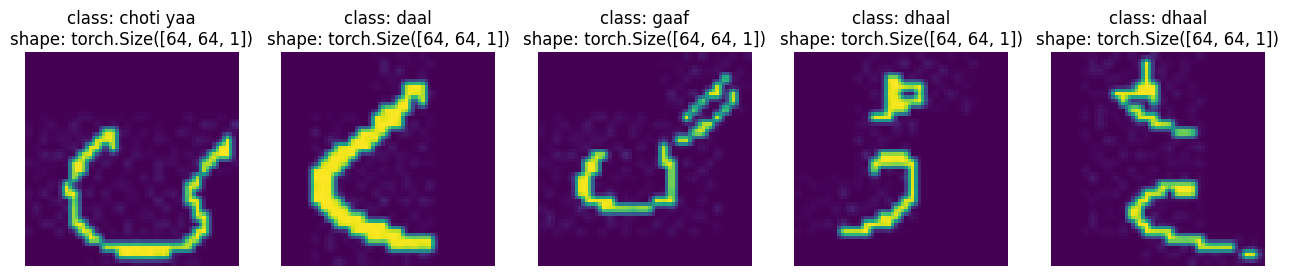

In [212]:
display_random_images(train_data_custom, 
                      n=5, 
                      classes=class_names,
                      seed=None)

## Turn custom loaded images into DataLoader's

In [213]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fe4822a62e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe483bf88b0>)

In [214]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 1, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Model: TinyVGG 

In [215]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

In [216]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7fe480338400>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe48031b9a0>)

In [217]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=1, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=23, bias=True)
  )
)

In [218]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 1, 64, 64])

Output logits:
tensor([[ 0.0123, -0.0259, -0.0441, -0.0003, -0.0054, -0.0333, -0.0347,  0.0571,
          0.0451, -0.0274, -0.0149,  0.0040,  0.0225,  0.0022, -0.0015,  0.0138,
         -0.0214, -0.0011, -0.0314, -0.0402, -0.0263,  0.0127,  0.0373]])

Output prediction probabilities:
tensor([[0.0442, 0.0425, 0.0418, 0.0436, 0.0434, 0.0422, 0.0422, 0.0462, 0.0457,
         0.0425, 0.0430, 0.0438, 0.0446, 0.0438, 0.0436, 0.0443, 0.0427, 0.0436,
         0.0423, 0.0419, 0.0425, 0.0442, 0.0453]])

Output prediction label:
tensor([7])

Actual label:
17


## Use torchinfo to get an idea of the shapes going through our model

In [219]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 1, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 23]                   --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           100
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Create train & test loop functions

In [220]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [221]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Creating a train() function to combine train_step() and test_step()

In [222]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## Train and Evaluate Model

In [223]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=1, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1071 | train_acc: 0.6650 | test_loss: 0.6363 | test_acc: 0.8130
Epoch: 2 | train_loss: 0.4602 | train_acc: 0.8580 | test_loss: 0.3742 | test_acc: 0.8803
Epoch: 3 | train_loss: 0.2688 | train_acc: 0.9151 | test_loss: 0.3027 | test_acc: 0.9004
Epoch: 4 | train_loss: 0.1876 | train_acc: 0.9412 | test_loss: 0.2715 | test_acc: 0.9194
Epoch: 5 | train_loss: 0.1346 | train_acc: 0.9558 | test_loss: 0.3321 | test_acc: 0.9145
Total training time: 493.032 seconds


In [224]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [225]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

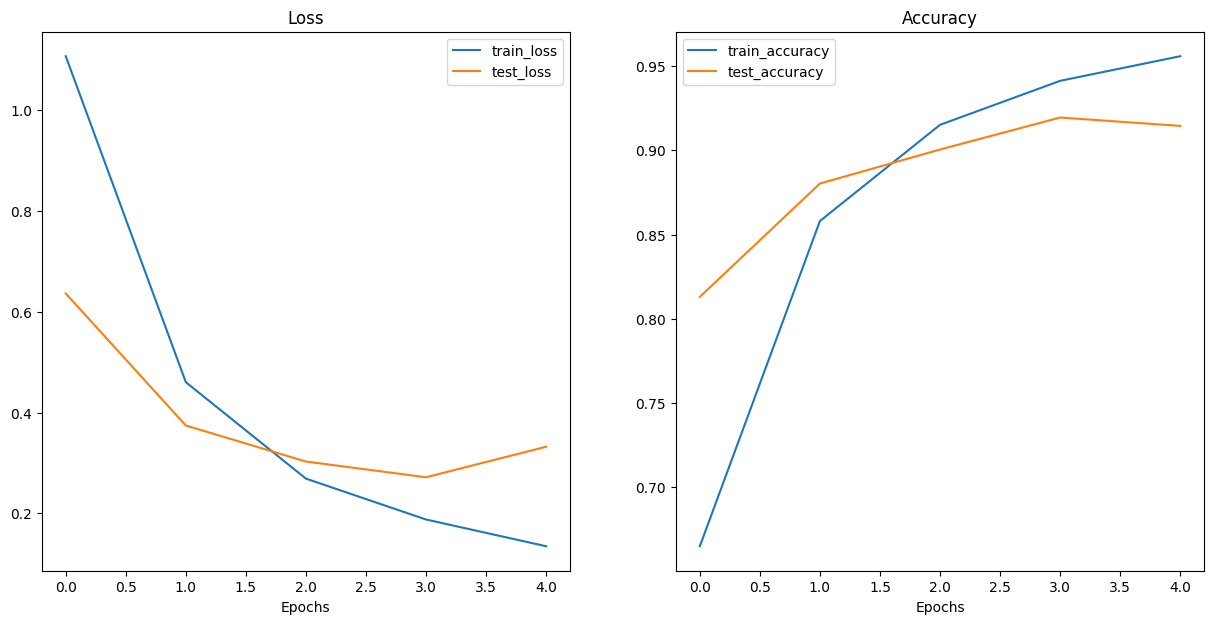

In [226]:
plot_loss_curves(model_0_results)

## Make a prediction on a custom image

In [254]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # Load in custom image and convert the tensor values to float32
    custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    custom_image = custom_image / 255. 
    # Create transform pipleine to resize image
    custom_image_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=1),
    ])

    # Transform target image
    custom_image_transformed = custom_image_transform(custom_image)

    model_0.eval()
    with torch.inference_mode():
      # Add an extra dimension to image
      custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)      
      # Make a prediction on image with an extra dimension
      custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

    # Print out prediction logits
    print(f"Prediction logits: {custom_image_pred}")

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
    print(f"Prediction probabilities: {custom_image_pred_probs}")

    # Convert prediction probabilities -> prediction labels
    custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
    print(f"Prediction label: {custom_image_pred_label}")

    # Find the predicted label
    custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(custom_image.permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
            title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
    else: 
            title = f"Pred: {custom_image_pred_label} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [260]:
custom_image_path = '/content/drive/MyDrive/AI_Mini_Project/data/urdu_characters/test/ayn/ayn (102).jpg'

Prediction logits: tensor([[-40.3713, -32.4563,   8.1371, -34.1985, -10.0316, -10.0275, -13.8507,
         -12.2261, -23.5844, -16.7672, -32.3255,   3.0744,  -3.2012,  -7.7045,
         -12.5189,  -8.2085,  -2.8842, -11.7629,  -0.5060, -24.4895, -29.3280,
         -10.0014, -17.7264]])
Prediction probabilities: tensor([[8.5166e-22, 2.3319e-18, 9.9351e-01, 4.0838e-19, 1.2782e-08, 1.2835e-08,
         2.8053e-10, 1.4241e-09, 1.6623e-14, 1.5184e-11, 2.6576e-18, 6.2875e-03,
         1.1830e-05, 1.3100e-07, 1.0626e-09, 7.9138e-08, 1.6243e-05, 2.2632e-09,
         1.7519e-04, 6.7241e-15, 5.3247e-17, 1.3174e-08, 5.8184e-12]])
Prediction label: tensor([2])


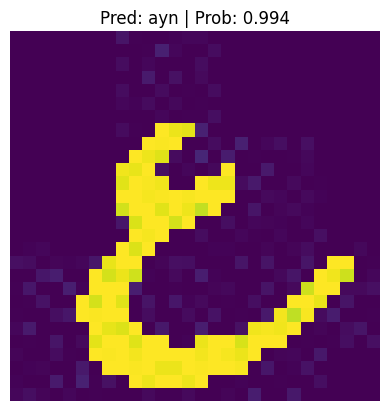

In [261]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    device=device)

## Save model

In [262]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("/content/drive/MyDrive/AI_Mini_Project/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: /content/drive/MyDrive/AI_Mini_Project/models/01_pytorch_workflow_model_0.pth


In [265]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = TinyVGG(input_shape=1, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device)

In [266]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Prediction logits: tensor([[-40.3713, -32.4563,   8.1371, -34.1985, -10.0316, -10.0275, -13.8507,
         -12.2261, -23.5844, -16.7672, -32.3255,   3.0744,  -3.2012,  -7.7045,
         -12.5189,  -8.2085,  -2.8842, -11.7629,  -0.5060, -24.4895, -29.3280,
         -10.0014, -17.7264]])
Prediction probabilities: tensor([[8.5166e-22, 2.3319e-18, 9.9351e-01, 4.0838e-19, 1.2782e-08, 1.2835e-08,
         2.8053e-10, 1.4241e-09, 1.6623e-14, 1.5184e-11, 2.6576e-18, 6.2875e-03,
         1.1830e-05, 1.3100e-07, 1.0626e-09, 7.9138e-08, 1.6243e-05, 2.2632e-09,
         1.7519e-04, 6.7241e-15, 5.3247e-17, 1.3174e-08, 5.8184e-12]])
Prediction label: tensor([2])


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


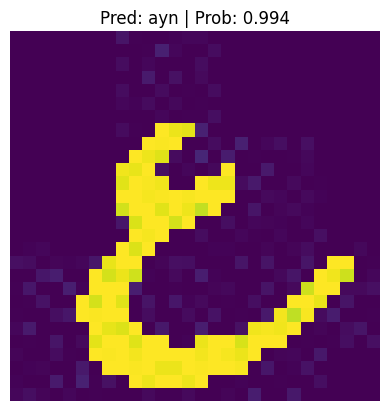

In [267]:
# Pred on our custom image
pred_and_plot_image(model=loaded_model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    device=device)